In [1]:
import sqlite3
from sqlite3 import Error

import string
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [2]:
def create_connection(db_file):
    """ 
    create a database connection to a SQLite database specified by the db_file
    :param db_file: path to database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

def run_query(conn, query):
    """
    query all rows in the tasks table
    :param conn: the Connection object
    :param query: query used on db
    :return:
    """
    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()
    return rows

def refine_col_names(list):
    names = []
    for col_info in list:
        names.append(col_info[1])
    return names

def close_connection(conn):
    """
    close database connection
    """
    if conn:
        conn.close()

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'

db_path = "filteredData/myYelpResData.db"
conn = create_connection(db_path)
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [4]:
# get restaurant filtered reviews & regular reviews
combined_list = run_query(conn, "SELECT * FROM combined WHERE flagged IN ('Y', 'N')")
combined_col_names = refine_col_names(run_query(conn, "PRAGMA table_info('combined')"))

# turn list to dataframe
combined = pd.DataFrame(combined_list, columns=combined_col_names)

combined.shape

(26958, 25)

In [5]:
combined.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,restaurantID,...,firstCount,usefulCount:1,coolCount:1,funnyCount:1,complimentCount,tipCount,fanCount,reviewer_flagged,posReviewCount,negReviewCount
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA,...,5,41,5,5,2,0,1,N,29,9
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA,...,0,0,0,0,0,0,0,N,11,0
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,N,pbEiXam9YJL3neCYHGwLUA,...,0,6,0,1,0,0,0,N,11,0
3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,N,pbEiXam9YJL3neCYHGwLUA,...,1,35,8,6,6,11,0,N,53,5
4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,N,pbEiXam9YJL3neCYHGwLUA,...,61,1650,679,417,283,22,70,N,629,231


In [6]:
cols = ['reviewContent', 'rating', 'flagged', 
        'friendCount', 'reviewCount', 'firstCount', 'fanCount', 'reviewer_flagged', 
        'posReviewCount', 'negReviewCount'
        ]
data = combined[cols]
data.head()

,reviewContent,rating,flagged,friendCount,reviewCount,firstCount,fanCount,reviewer_flagged,posReviewCount,negReviewCount
0,"Unlike Next, which we'd eaten at the previous ...",5,N,11,48,5,1,N,29,9
1,Probably one of the best meals I've had ever. ...,5,N,0,4,0,0,N,11,0
2,Service was impeccable. Experience and present...,3,N,2,11,0,0,N,11,0
3,"The problem with places like this, given the e...",3,N,84,60,1,0,N,53,5
4,I have no idea how to write my review - dining...,5,N,333,1209,61,70,N,629,231


In [7]:
data['flagged'] = (data['flagged']=='Y').astype(int)
data['reviewer_flagged'] = (data['reviewer_flagged']=='Y').astype(int)
data['ratio'] = data['posReviewCount']/data['negReviewCount']
data['ratio'] = data['ratio'].replace(np.inf, 0)
data['ratio'] = data['ratio'].replace(np.nan, 0)
data.head()

,reviewContent,rating,flagged,friendCount,reviewCount,firstCount,fanCount,reviewer_flagged,posReviewCount,negReviewCount,ratio
0,"Unlike Next, which we'd eaten at the previous ...",5,0,11,48,5,1,0,29,9,3.222222
1,Probably one of the best meals I've had ever. ...,5,0,0,4,0,0,0,11,0,0.000000
2,Service was impeccable. Experience and present...,3,0,2,11,0,0,0,11,0,0.000000
3,"The problem with places like this, given the e...",3,0,84,60,1,0,0,53,5,10.600000
4,I have no idea how to write my review - dining...,5,0,333,1209,61,70,0,629,231,2.722944


In [8]:
check = []
for i in cols:
    if (i != 'reviewContent'):
        check.append(np.isfinite(data[i]).all())
check

[True, True, True, True, True, True, True, True, True]

In [9]:
data.isnull().sum()

reviewContent       0
rating              0
flagged             0
friendCount         0
reviewCount         0
firstCount          0
fanCount            0
reviewer_flagged    0
posReviewCount      0
negReviewCount      0
ratio               0
dtype: int64

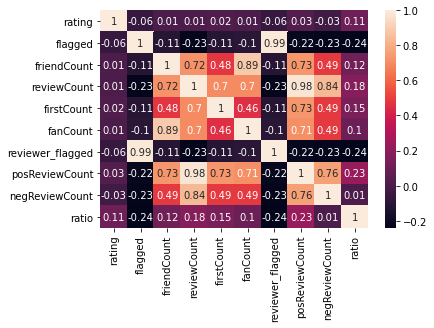

In [10]:
# create a correlation matrix that measures the linear relationships between the variables
correlation_matrix = data.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [11]:
correlation_matrix

,rating,flagged,friendCount,reviewCount,firstCount,fanCount,reviewer_flagged,posReviewCount,negReviewCount,ratio
rating,1.00,-0.06,0.01,0.01,0.02,0.01,-0.06,0.03,-0.03,0.11
flagged,-0.06,1.00,-0.11,-0.23,-0.11,-0.10,0.99,-0.22,-0.23,-0.24
friendCount,0.01,-0.11,1.00,0.72,0.48,0.89,-0.11,0.73,0.49,0.12
reviewCount,0.01,-0.23,0.72,1.00,0.70,0.70,-0.23,0.98,0.84,0.18
firstCount,0.02,-0.11,0.48,0.70,1.00,0.46,-0.11,0.73,0.49,0.15
fanCount,0.01,-0.10,0.89,0.70,0.46,1.00,-0.10,0.71,0.49,0.10
reviewer_flagged,-0.06,0.99,-0.11,-0.23,-0.11,-0.10,1.00,-0.22,-0.23,-0.24
posReviewCount,0.03,-0.22,0.73,0.98,0.73,0.71,-0.22,1.00,0.76,0.23
negReviewCount,-0.03,-0.23,0.49,0.84,0.49,0.49,-0.23,0.76,1.00,0.01
ratio,0.11,-0.24,0.12,0.18,0.15,0.10,-0.24,0.23,0.01,1.00


Since all variables seem to have quite low correlation with our target variable 'flagged', we'll drop the ones that have correlation less than 0.1.  
So, we'll use friendCount, reviewCount, firstCount, reviewer_flagged and ratio as our features.  
(we drop posReviewCount and negReviewCount because ratio is calculated by posReviewCount/negReviewCount)

In [12]:
data = data.drop(['rating', 'fanCount', 'posReviewCount', 'negReviewCount'], axis=1)
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,"Unlike Next, which we'd eaten at the previous ...",0,11,48,5,0,3.222222
1,Probably one of the best meals I've had ever. ...,0,0,4,0,0,0.000000
2,Service was impeccable. Experience and present...,0,2,11,0,0,0.000000
3,"The problem with places like this, given the e...",0,84,60,1,0,10.600000
4,I have no idea how to write my review - dining...,0,333,1209,61,0,2.722944


In [13]:
def lower_case(text):
    return text.lower()

data['reviewContent'] = data['reviewContent'].apply(lower_case)
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,"unlike next, which we'd eaten at the previous ...",0,11,48,5,0,3.222222
1,probably one of the best meals i've had ever. ...,0,0,4,0,0,0.000000
2,service was impeccable. experience and present...,0,2,11,0,0,0.000000
3,"the problem with places like this, given the e...",0,84,60,1,0,10.600000
4,i have no idea how to write my review - dining...,0,333,1209,61,0,2.722944


In [14]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['reviewContent'] = data['reviewContent'].apply(remove_punctuation)
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,unlike next which wed eaten at the previous ni...,0,11,48,5,0,3.222222
1,probably one of the best meals ive had ever i...,0,0,4,0,0,0.000000
2,service was impeccable experience and presenta...,0,2,11,0,0,0.000000
3,the problem with places like this given the ex...,0,84,60,1,0,10.600000
4,i have no idea how to write my review dining ...,0,333,1209,61,0,2.722944


In [15]:
stop_words = stopwords.words('english')

def remove_stop_words(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data['reviewContent'] = data['reviewContent'].apply(remove_stop_words)
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,unlike next wed eaten previous night dish comp...,0,11,48,5,0,3.222222
1,probably one best meals ive ever performance f...,0,0,4,0,0,0.000000
2,service impeccable experience presentation coo...,0,2,11,0,0,0.000000
3,problem places like given exhorbitant cost med...,0,84,60,1,0,10.600000
4,idea write review dining alinea brings whole d...,0,333,1209,61,0,2.722944


In [16]:
# lemmatizer = WordNetLemmatizer()

# def lemmatize_words(text):
#     return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

data['reviewContent'] = data['reviewContent'].apply(lemmatize_words)
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,unlike next wed eaten previous night dish comp...,0,11,48,5,0,3.222222
1,probably one best meal ive ever performance fo...,0,0,4,0,0,0.000000
2,service impeccable experience presentation coo...,0,2,11,0,0,0.000000
3,problem place like give exhorbitant cost mediu...,0,84,60,1,0,10.600000
4,idea write review din alinea brings whole diff...,0,333,1209,61,0,2.722944


In [17]:
numberical_cols = ['friendCount', 'reviewCount', 'firstCount', 'ratio']

for i in numberical_cols:
    scale = StandardScaler().fit(data[[i]])
    data[i] = scale.transform(data[[i]])
data.head()

,reviewContent,flagged,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
0,unlike next wed eaten previous night dish comp...,0,-0.166242,-0.219306,-0.084727,0,-0.205781
1,probably one best meal ive ever performance fo...,0,-0.216063,-0.429850,-0.208246,0,-0.687585
2,service impeccable experience presentation coo...,0,-0.207005,-0.396355,-0.208246,0,-0.687585
3,problem place like give exhorbitant cost mediu...,0,0.164389,-0.161885,-0.183542,0,0.897385
4,idea write review din alinea brings whole diff...,0,1.292160,5.336181,1.298680,0,-0.280435


In [18]:
data.shape

(26958, 7)

In [19]:
# Set data
X = data.drop('flagged', axis=1)
y = data['flagged']

print(X.shape, y.shape)

(26958, 6) (26958,)


In [20]:
# split reviews into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20218, 6) (6740, 6) (20218,) (6740,)


In [21]:
X_train.head()

,reviewContent,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
3303,put simply food great service drink suck perio...,0.060218,0.144360,0.384643,0,0.147998
14885,live new york city im native chicagoan wheneve...,-0.003191,1.264071,0.458754,0,0.040106
20777,cant find good place seafood chicago great oys...,-0.216063,-0.401140,-0.183542,1,-0.164246
21561,recently best friend come visit excite bring u...,-0.161713,-0.439420,-0.208246,1,-0.538059
8224,there nothing like eat outside irazu summer se...,-0.216063,-0.396355,-0.208246,0,-0.687585


In [22]:
X_test.head()

,reviewContent,friendCount,reviewCount,firstCount,reviewer_flagged,ratio
4690,tremendous fresh fish casual atmosphere dont l...,-0.207005,-0.434635,-0.208246,0,-0.239008
21317,valet may grouchy place delicnow midwest love ...,-0.216063,-0.377214,-0.208246,1,-0.463297
23382,really like sagnaki cheese chicken riggati nev...,-0.216063,-0.391570,-0.208246,1,-0.687585
23974,im chinese american enjoys spicy food lao sze ...,-0.216063,-0.429850,-0.208246,1,-0.637743
24885,make feel like homepeking duck magnificent clo...,-0.216063,-0.429850,-0.208246,1,-0.239008


In [23]:
# count vectorizor
count_vectorizor = CountVectorizer()
count_vectorizor.fit(X_train['reviewContent'])
X_cv = count_vectorizor.transform(X_train['reviewContent'])
X_cv_test = count_vectorizor.transform(X_test['reviewContent'])

cv_stack = sp.sparse.hstack([X_cv, X_train[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")
cv_stack_test = sp.sparse.hstack([X_cv_test, X_test[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")

# count vectorizor ngram
count_ngram_vectorizor = CountVectorizer(ngram_range=(1, 3))
count_ngram_vectorizor.fit(X_train['reviewContent'])
X_cv_ngram = count_ngram_vectorizor.transform(X_train['reviewContent'])
X_cv_ngram_test = count_ngram_vectorizor.transform(X_test['reviewContent'])

cv_ngram_stack = sp.sparse.hstack([X_cv_ngram, X_train[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")
cv_ngram_stack_test = sp.sparse.hstack([X_cv_ngram_test, X_test[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")

# tf-idf vectorizor
tfidf_vectorizor = TfidfVectorizer()
tfidf_vectorizor.fit(X_train['reviewContent'])
X_tv = tfidf_vectorizor.transform(X_train['reviewContent'])
X_tv_test = tfidf_vectorizor.transform(X_test['reviewContent'])

tv_stack = sp.sparse.hstack([X_tv, X_train[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")
tv_stack_test = sp.sparse.hstack([X_tv_test, X_test[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")

# tf-idf vectorizor ngram
tfidf_ngram_vectorizor = TfidfVectorizer(ngram_range=(1, 3))
tfidf_ngram_vectorizor.fit(X_train['reviewContent'])
X_tv_ngram = tfidf_ngram_vectorizor.transform(X_train['reviewContent'])
X_tv_ngram_test = tfidf_ngram_vectorizor.transform(X_test['reviewContent'])

tv_ngram_stack = sp.sparse.hstack([X_tv, X_train[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")
tv_ngram_stack_test = sp.sparse.hstack([X_tv_test, X_test[['friendCount', 'reviewCount', 'firstCount', 'ratio']].values], format="csr")

In [24]:
# logistic regression w/ count vectorizor
print("logistic regression w/ count vectorizor :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr_cv = LogisticRegression(C=c, max_iter=20500)
    lr_cv.fit(cv_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, lr_cv.predict(cv_stack_test))))

logistic regression w/ count vectorizor :

Accuracy for C = 0.01 : 0.8172106824925816
Accuracy for C = 0.05 : 0.8268545994065282
Accuracy for C = 0.25 : 0.8206231454005934
Accuracy for C = 0.5 : 0.8137982195845698
Accuracy for C = 1 : 0.8106824925816024


In [25]:
# logistic regression w/ count vectorizor ngram
print("logistic regression w/ count vectorizor ngram :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr_cv_ngram = LogisticRegression(C=c, max_iter=20500)
    lr_cv_ngram.fit(cv_ngram_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, lr_cv_ngram.predict(cv_ngram_stack_test))))

logistic regression w/ count vectorizor ngram :

Accuracy for C = 0.01 : 0.8135014836795252
Accuracy for C = 0.05 : 0.8201780415430268
Accuracy for C = 0.25 : 0.8170623145400594
Accuracy for C = 0.5 : 0.8166172106824926
Accuracy for C = 1 : 0.8124629080118695


In [26]:
# logistic regression w/ tf-idf vectorizor
print("logistic regression w/ tf-idf vectorizor :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr_tv = LogisticRegression(C=c, max_iter=20500)
    lr_tv.fit(tv_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, lr_tv.predict(tv_stack_test))))

logistic regression w/ tf-idf vectorizor :

Accuracy for C = 0.01 : 0.7657270029673591
Accuracy for C = 0.05 : 0.8357566765578635
Accuracy for C = 0.25 : 0.8492581602373888
Accuracy for C = 0.5 : 0.8474777448071217
Accuracy for C = 1 : 0.8465875370919881


In [27]:
# logistic regression w/ tf-idf vectorizor ngram
print("logistic regression w/ tf-idf vectorizor ngram :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr_tv_ngram = LogisticRegression(C=c, max_iter=20500)
    lr_tv_ngram.fit(tv_ngram_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, lr_tv_ngram.predict(tv_ngram_stack_test))))

logistic regression w/ tf-idf vectorizor ngram :

Accuracy for C = 0.01 : 0.7657270029673591
Accuracy for C = 0.05 : 0.8357566765578635
Accuracy for C = 0.25 : 0.8492581602373888
Accuracy for C = 0.5 : 0.8474777448071217
Accuracy for C = 1 : 0.8465875370919881


In [28]:
# linear SVM w/ count vectorizor
print("linear SVM w/ count vectorizor :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    svm_cv = LinearSVC(C=c, max_iter=20500)
    svm_cv.fit(cv_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, svm_cv.predict(cv_stack_test))))

linear SVM w/ count vectorizor :

Accuracy for C = 0.01 : 0.8219584569732937
Accuracy for C = 0.05 : 0.8094955489614243
Accuracy for C = 0.25 : 0.7997032640949555
Accuracy for C = 0.5 : 0.7936201780415431
Accuracy for C = 1 : 0.783086053412463


In [29]:
# linear SVM w/ count vectorizor ngram
print("linear SVM w/ count vectorizor ngram :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    svm_cv_ngram = LinearSVC(C=c, max_iter=20500)
    svm_cv_ngram.fit(cv_ngram_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, svm_cv_ngram.predict(cv_ngram_stack_test))))

linear SVM w/ count vectorizor ngram :

Accuracy for C = 0.01 : 0.8167655786350149
Accuracy for C = 0.05 : 0.8083086053412463
Accuracy for C = 0.25 : 0.8020771513353115
Accuracy for C = 0.5 : 0.7976261127596439
Accuracy for C = 1 : 0.7939169139465876


In [30]:
# linear SVM w/ tf-idf vectorizor
print("linear SVM w/ tf-idf vectorizor :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    svm_tv = LinearSVC(C=c, max_iter=20500)
    svm_tv.fit(tv_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, svm_tv.predict(tv_stack_test))))

linear SVM w/ tf-idf vectorizor :

Accuracy for C = 0.01 : 0.8271513353115727
Accuracy for C = 0.05 : 0.841246290801187
Accuracy for C = 0.25 : 0.8356083086053413
Accuracy for C = 0.5 : 0.8292284866468843
Accuracy for C = 1 : 0.8219584569732937


In [31]:
# linear SVM w/ tf-idf vectorizor ngram
print("linear SVM w/ tf-idf vectorizor ngram :\n")
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    svm_tv_ngram = LinearSVC(C=c, max_iter=20500)
    svm_tv_ngram.fit(tv_ngram_stack, y_train)
    print("Accuracy for C = %s : %s" % (c, accuracy_score(y_test, svm_tv_ngram.predict(tv_ngram_stack_test))))

linear SVM w/ tf-idf vectorizor ngram :

Accuracy for C = 0.01 : 0.8271513353115727
Accuracy for C = 0.05 : 0.841246290801187
Accuracy for C = 0.25 : 0.8356083086053413
Accuracy for C = 0.5 : 0.8292284866468843
Accuracy for C = 1 : 0.8219584569732937
